In [1]:
# Importar las librerías necesarias
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU

In [2]:
### DUDAS

# tenemos que usar convolusionales o LSTM? 
#que es el dense? 
# agregar features?
# como se que me salió bien? se mide con metricas?
# tenemos que normalizar? se puede normalizar todo el data set antes o es despues de separar en train y test? es con la media del train? como separar en train y test una serie de tiempo?
# nuestro input es el window size para el LSTM y la cantidad de caracteristicas? diferencia entre las convolusionales 2D?
# si tenemos 2000 datos por feature, cuantas neuronas tenemos de input? 2000? nfeatures segun yo o mas bien, como relaciono el input shape con las neuronas?
# segun yo cada feature representaba una neurona para la capa inicial, o es cada dato, o es independiente?
# lo anterior como sería con convolusionales? los pixeles en convolusionales son features? explicar el por el video que vi
# como sabemos que capa despues de la anterior, es decir LSTM y luego dropout o leaky relu o que onda
# en que parte se cambia la funcion de costo? es decir cual es la diferencia entre como planteamos BinaryCrossentropy en GAN normal?
# Para que sirve import tqdm?
# Tarda mucho en correr?

# que significado tiene la salida del modelo?
# podemos usar la misma arquitectura de las convolusionales solo cambiar la funcion de activacion final (creo)



In [3]:
# Separar en train y test el data set

def download_data(ticker: str, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data[['Adj Close']]  
    return data


def preprocess_data(data: pd.DataFrame):
    prices = data.iloc[:int(len(data) * 0.8)]
    r = (np.log(prices[['Adj Close']]/prices[['Adj Close']].shift(1))).dropna()
    mean = r.mean()
    std = r.std()
    r_norm = (r - mean)/std 
    
    return prices, r, r_norm

def split_train_test(data: pd.DataFrame):
    x_train = data.iloc[:int(len(data) * 0.8)]
    x_test = data.iloc[int(len(data) * 0.8):]
    
    return x_train, x_test

# input_shape = (50, 3)  # 50 pasos en el tiempo (ventana), 3 features

# # Crear el modelo
# model = Sequential()
# model.add(LSTM(64, input_shape=input_shape, return_sequences=True))



def generator(data: pd.DataFrame):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(data.shape[0], 1)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(LSTM(64))
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dense(252))
    
    return model

def discriminator():
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(252, 1)))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.4))
    model.add(LSTM(100))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))  # salida binaria para clasificar real o falso

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [4]:
ticker = "MANU"  
start_date = '2014-10-29'
end_date = '2024-10-30'
data = download_data(ticker, start_date, end_date)
precios, data, data_norm = preprocess_data(data)
x_train, x_test = split_train_test(data_norm)
gen_model = generator(x_train)
disc_model = discriminator()

[*********************100%%**********************]  1 of 1 completed
C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


#A como lo entiendo esto se mantendría igual lo que cambia del promedio de la resta es mas adelante
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def discriminator_loss(y_true, y_fake):
    real_loss = loss_function(tf.ones_like(y_true), y_true)
    fake_loss = loss_function(tf.zeros_like(y_fake), y_fake)
    return real_loss + fake_loss


def generator_loss(y_fake):
    return loss_function(tf.ones_like(y_fake), y_fake)

In [5]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [6]:
gen_loss_history = []
disc_loss_history = []

@tf.function
def train_step(data, batch_size = 100):
    noise = tf.random.normal([batch_size, len(data), 1])
    
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = gen_model(noise, training = True)
        
        y_real = disc_model(data, training = True)
        y_fake = disc_model(generated_data, training = True)
        
        gen_loss = -tf.math.reduce_mean(y_fake) # o simplemente -tf.math.reduce_mean(y_fake) y sin las funciones de gen_loss y disc_loss
        disc_loss = tf.reduce_mean(y_fake) - tf.reduce_mean(y_real) #o simplemente tf.reduce_mean(y_fake) - tf.reduce_mean(y_real)
        
        
    gradients_gen = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, disc_model.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_gen, gen_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, disc_model.trainable_variables))
    
    
    return gen_loss, disc_loss


In [7]:
num_batches = x_train.shape[0] // 200
for epoch in range(100):
    for i in tqdm.tqdm(range(num_batches)):
        batch = x_train[i*200:(1+i)*200]
        gen_loss, disc_loss = train_step(batch)

        gen_loss_history.append(gen_loss.numpy())
        disc_loss_history.append(disc_loss.numpy())

100%|██████████| 8/8 [00:12<00:00,  1.51s/it]


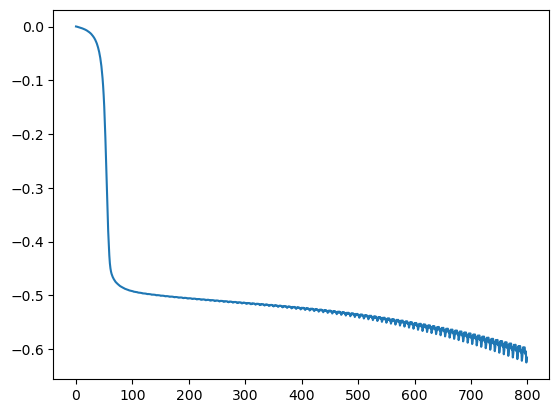

In [8]:
plt.plot(disc_loss_history)

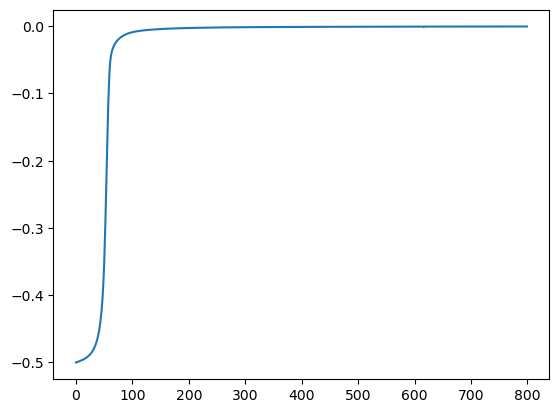

In [9]:
plt.plot(gen_loss_history)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


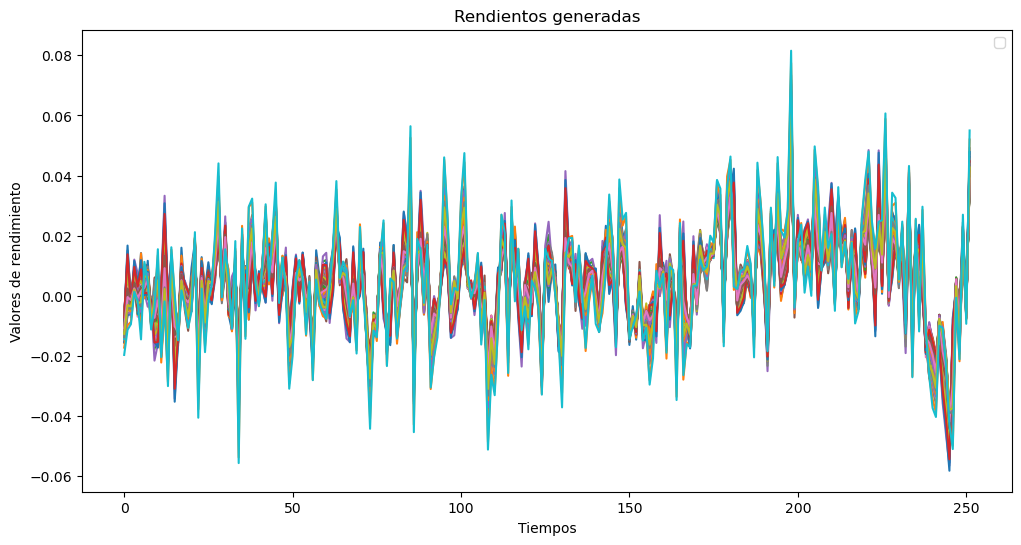

In [10]:
noise = tf.random.normal([100, 2000, 1])  

generated_series = gen_model(noise, training=False)  

plt.figure(figsize=(12, 6))
for j in range(100):  
    plt.plot(generated_series[j, :])

plt.title("Rendientos generadas")
plt.xlabel("Tiempos")
plt.ylabel("Valores de rendimiento")
plt.legend()
plt.show()

In [11]:
scenarios = generated_series.numpy().tolist()

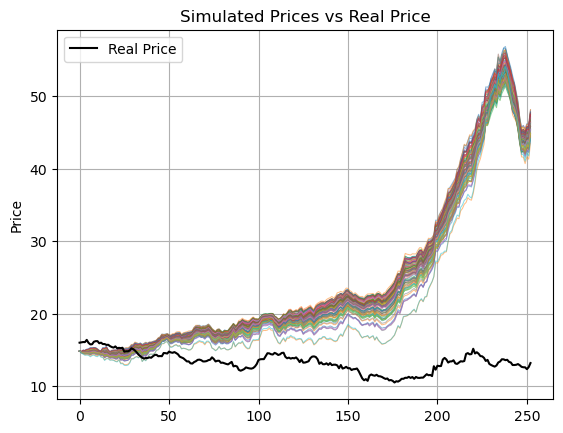

In [12]:
S0 = precios['Adj Close'].iloc[0]

data_n = []

for scenario in scenarios:
    prices = [S0]
    for log_return in scenario:
        next_price = prices[-1] * np.exp(log_return)
        prices.append(next_price)
    data_n.append(prices)

for prices in data_n:
    plt.plot(prices, alpha=0.5, linewidth=0.75)

plt.plot((precios[1760:]).values, label='Real Price', color='black', linewidth=1.5)
plt.title('Simulated Prices vs Real Price')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()


In [13]:
# el mismo espacio de tiempo
# mejorar la red neuronal
# desnormalizar?
# logaritmicos?
# como se que el modelo aprendió?
# Usar semillas